In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from tqdm.notebook import trange
import anytree
import torch


np.set_printoptions(suppress=True, precision=5)

In [2]:
def MUGW_fused(r, eps, rho,alph,img1 = None,img2 = None,n_its = 80,
    divergence='KL',
    max_iter=10000,plan_cvgce_thres = 1e-6,
    sink_cvgce_thres=1e-5,
    n_its_check_cvgce=10,
    sink_n_its_check_cvgce=10,
    pot_large=1e10,
    verbose=False,
    plot_intermediate = False):
    
    forward = [node for node in anytree.PreOrderIter(r)]
    i = 0
    update = np.inf
    for i in trange(n_its):
        #Sinkhorn
        r = umgw.tree_sinkhorn(r,eps,rho,divergence = divergence,max_iter=max_iter,cvgce_thres=sink_cvgce_thres,n_its_check_cvgce=n_its_check_cvgce,pot_large=pot_large,verbose=verbose)
        
        #Update pis and costs
        for node in forward:
            if node.is_root:
                continue
            old_pi = node.pi
            node.old_pi = old_pi
            new_pi = node.pi_left[:, None] * node.K * node.pi_right[None, :] #/ node.marginal
            tmp2 = np.sqrt(np.sum(new_pi)/np.sum(old_pi))
            node.pi =  (1/tmp2) * new_pi

            node.cost = node.t * umgw.compute_local_cost(torch.from_numpy(node.pi), torch.from_numpy(np.ones(len(node.parent.M))/len(node.parent.M)), torch.from_numpy(node.parent.M), torch.from_numpy(np.ones(len(node.M))/len(node.M)), torch.from_numpy(node.M), eps, node.parent.rho, node.rho)
            node.cost += eps * torch.sum(torch.from_numpy(node.pi) * (torch.from_numpy(node.pi) / torch.from_numpy(node.marginal**len(node.children)) + 1e-10).log())
            node.cost = alph * node.cost
            node.cost = node.cost + node.t *(1/2)*(1-alph) * node.ot_cost
            
            node.cost = np.array(node.cost)
        
        if i % n_its_check_cvgce == 0:
            update = max([np.abs(node.old_pi - node.pi).max() \
                          / max(1., node.old_pi.max(), node.pi.max()) \
                        for node in forward[1:]])
        i += 1
        if update < plan_cvgce_thres:
            break
    
    print("Terminated after {0} iterations with last update {1}.".format(i, update))
    return r

In [3]:
def mm_from_img(img,metric="euclidean",norm_grid = True, norm_meas=True):
    assert img.ndim == 2, "img needs to be 2d array"
    supp = np.dstack(np.where(img > 0))[0]
    height = img[supp[:,0],supp[:,1]]
    if norm_grid:
        unit_length = np.linalg.norm(np.shape(img) - np.array([1,1]))
        supp = supp / unit_length
    if norm_meas:
        height /= np.sum(height)
    #if normalize_
    M = ot.dist(supp,supp,metric=metric)
    return [supp,M,height]

In [4]:
def vis_gw_plan(img1,pos1,pos2,height2,P,return_img = False, plot_img = True,sub_box=False,img1_given =False):
    #Colour img1
    nx,ny = np.shape(img1)[:2]
    if sub_box:
        x_min = int(np.min(pos1[:,0]))
        x_max = int(np.max(pos1[:,0]))
        y_min = int(np.min(pos1[:,1]))
        y_max = int(np.max(pos1[:,1]))
    else:
        x_min = 0
        x_max = nx
        y_min = 0
        y_max = ny
    if img1_given:
        img1_col = img1
    else:
        img1_col = np.zeros((nx, ny, 3))
        for i in range(nx):
            for j in range(ny):
                if img1[i, j] != 0:
                    col = [1, (i - x_min) / (x_max - x_min), (j - y_min) / (y_max - y_min)]
                    img1_col[i, j] = col

    #Calculate colours in img2 according to P
    n_pts1 = len(pos1)
    n_pts2 = len(pos2)
    counts = np.zeros(n_pts2)
    cols = np.zeros((n_pts2,3))
    for j in range(n_pts2):
        for i in range(n_pts1):
            if P[i,j] != 0:
                counts[j] += 1
                x,y = pos1[i]
                #print(x,y)
                cols[j] += P[i,j]/height2[j] * img1_col[x,y]
        cols[j] = cols[j] #/ height2[j]
        
    #Colour img2
    img2_col = np.zeros((nx,ny,3))
    for i in range(n_pts2):
        x,y = pos2[i]
        img2_col[x,y] = cols[i]

    #Plot
    if plot_img:
        fig, ax = plt.subplots(1,2,figsize = (10,20))
        ax[0].imshow(img1_col)
        ax[1].imshow(img2_col)
        plt.show()
    if return_img:
        return img1_col.clip(min=0,max=1),img2_col.clip(min=0,max=1)

In [5]:
#choose to load 81 or 98:
#num = "81"
num = "98"

data = [np.load("./{0}_0.npy".format(num)),np.load("./{0}_1.npy".format(num))]
data_col = [np.load("./c_{0}_0.npy".format(num)),np.load("./c_{0}_1.npy".format(num))]

In [6]:
#create mm-spaces
mms = [mm_from_img(data[i],norm_grid=False) for i in range(2)]

In [7]:
#label costs
L = []
labels = []
for pos in mms[0][0]:
    if data[0][pos[0],pos[1]] != 0 and np.all(data_col[0][pos[0],pos[1]] == [1,0,0]):
        label = 0
    elif data[0][pos[0],pos[1]] != 0 and np.all(data_col[0][pos[0],pos[1]] == [0,0,1]):
        label = 1
    labels.append(label)
L.append(np.array(labels))

labels = []
for pos in mms[1][0]:
    if data[1][pos[0],pos[1]] != 0 and np.all(data_col[1][pos[0],pos[1]] == [1,0,0]):
        label = 0
    elif data[1][pos[0],pos[1]] != 0 and np.all(data_col[1][pos[0],pos[1]] == [0,0,1]):
        label = 1
    labels.append(label)
L.append(np.array(labels))

In [8]:
t = 0.5

In [9]:
nx,ny = np.shape(data[0])
grid = np.ones((nx,ny))
Y,M_Y,height_Y = mm_from_img(grid,norm_grid=False)

In [10]:
labels_Y = np.zeros(len(Y))
for i in range(len(Y)):
    if Y[i][1] < ny/2:
        labels_Y[i] = 1

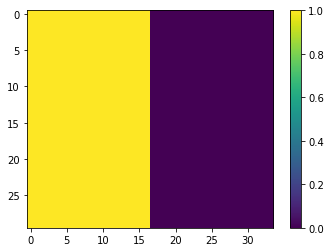

In [11]:
#plot labelled mm-space of barycenter
plt.imshow(labels_Y.reshape(nx,ny))
plt.colorbar()
plt.show()

In [12]:
max_dist = np.linalg.norm(np.array((nx,ny)) - np.array([1,1]))

In [13]:
ot_cost_1 = ot.dist(L[0].reshape(-1,1),labels_Y.reshape(-1,1))

ot_cost_2 = ot.dist(labels_Y.reshape(-1,1),L[1].reshape(-1,1))

In [14]:
t = 0.5

In [15]:
import umgw

In [16]:
def proc(mm1,mm2,M_Y,max_dist,ot_cost_1,ot_cost_2,eps,t,alph,rho,grid):
    r = anytree.AnyNode(id=0)
    n1 = anytree.AnyNode(id=1,parent=r)
    n4 = anytree.AnyNode(id=2,parent=n1)

    r.t = None
    n1.t = t
    n4.t = 1-t
    forward = [node for node in anytree.PreOrderIter(r)]

    r.mu = mm1[2]
    r.M = mm1[1]/max_dist
    r.pi = None
    r.cost = None
    r.rho = rho

    #n1.mu = None #barycenter
    n1.rho = 0
    n1.M = M_Y /max_dist
    n1.pi = r.mu[:,None] * ot.unif(len(n1.M))[None,:]
    n1.pi = n1.pi / np.sum(n1.pi)

    n1.cost = np.array(umgw.compute_local_cost(torch.from_numpy(n1.pi),torch.from_numpy(r.mu),torch.from_numpy(r.M),torch.from_numpy(ot.unif(len(n1.M))),torch.from_numpy(n1.M),eps,rho,rho))
    #n1.cost = local_cost(n1.pi,r.M,n1.M)
    #tmp = ot.dist(mms[0][0],Y,metric="sqeuclidean")
    if ot_cost_1 is None:
        n1.ot_cost = np.zeros((np.shape(mm1)[0],np.shape(M_Y)[0]))
    else:
        n1.ot_cost = ot_cost_1


    n4.mu = mm2[2]
    n4.M = mm2[1]/max_dist
    n4.pi = ot.unif(len(n1.M))[:,None] * n4.mu[None,:]
    n4.pi = n4.pi / np.sum(n4.pi)
    #n4.rho = np.inf
    n4.rho = rho

    n4.cost = np.array(umgw.compute_local_cost(torch.from_numpy(n4.pi),torch.from_numpy(ot.unif(len(n1.M))),torch.from_numpy(n1.M),torch.from_numpy(n4.mu),torch.from_numpy(n4.M),eps,rho,rho))
    #n4.cost = local_cost(n4.pi,n1.M,n4.M)
    #tmp = ot.dist(Y,mms[1][0],metric="sqeuclidean")
    if ot_cost_2 is None:
        n4.ot_cost = np.zeros((np.shape(M_Y)[0],np.shape(mm1)[0]))
    else:
        n4.ot_cost = ot_cost_2


    result = MUGW_fused(r,eps= eps,rho=rho,alph=alph,plan_cvgce_thres=1e-6,sink_cvgce_thres=1e-7,n_its_check_cvgce=5,n_its = 200,img1 = None, img2 = None,plot_intermediate=False)
    return n1.marginal.reshape(np.shape(grid)),n1.pi,n4.pi

In [17]:
barys = []
pi1s = []
pi2s = []

In [18]:
#GW
eps = 0.0002
rho = np.inf
alph = 1
t = 0.5

bary_gw,pi1_gw,pi2_gw = proc(mms[0],mms[1],M_Y,max_dist,ot_cost_1,ot_cost_2,eps=eps,t = t,alph = alph,rho = rho,grid = grid)


  0%|          | 0/200 [00:00<?, ?it/s]

Terminated after 200 iterations with last update 1.0378185393231923e-06.


In [19]:
#UGW
eps = 0.0002
rho = 0.01
alph = 1
t = 0.5

bary_ugw,pi1_ugw,pi2_ugw = proc(mms[0],mms[1],M_Y,max_dist,ot_cost_1,ot_cost_2,eps=eps,t = t,alph = alph,rho = rho,grid = grid)


  0%|          | 0/200 [00:00<?, ?it/s]

Terminated after 200 iterations with last update 1.0677753990281837e-06.


In [20]:
#FGW
eps = 0.0002
rho = np.inf
alph = 0.5
t = 0.5

bary_fgw,pi1_fgw,pi2_fgw = proc(mms[0],mms[1],M_Y,max_dist,ot_cost_1,ot_cost_2,eps=eps,t = t,alph = alph,rho = rho,grid = grid)


  0%|          | 0/200 [00:00<?, ?it/s]

Terminated after 56 iterations with last update 4.617713729421864e-07.


In [21]:
#UFGW
eps = 0.0002
rho = 0.01
alph = 0.5
t = 0.5

bary_ufgw,pi1_ufgw,pi2_ufgw = proc(mms[0],mms[1],M_Y,max_dist,ot_cost_1,ot_cost_2,eps=eps,t = t,alph = alph,rho = rho,grid = grid)


  0%|          | 0/200 [00:00<?, ?it/s]

Terminated after 66 iterations with last update 3.612077625291237e-07.


In [22]:
#add all barycenters and plans to list
barylist = [bary_gw,bary_ugw,bary_fgw,bary_ufgw]
pilist = [[pi1_gw,pi2_gw],[pi1_ugw,pi2_ugw],[pi1_fgw,pi2_fgw],[pi1_ufgw,pi2_ufgw]]

In [23]:
#threshold barycenters and color according to transport
barylist_col = []
for i in range(4):
    pi1,pi2 = pilist[i]
    bary = barylist[i]
    bary_col_1 = vis_gw_plan(data_col[0],mms[0][0],Y,bary.flatten(),pi1,return_img=True,plot_img=False,sub_box=True,img1_given =True)[1]
    bary_col_2 = vis_gw_plan(data_col[1],mms[1][0],Y,bary.flatten(),pi2.T,return_img=True,plot_img=False,sub_box=True,img1_given =True)[1]
    
    bary_col = np.mean([bary_col_1,bary_col_2],axis=0)
    bary_col[bary < 0.0018] = [0,0,0]
    barylist_col.append(bary_col)

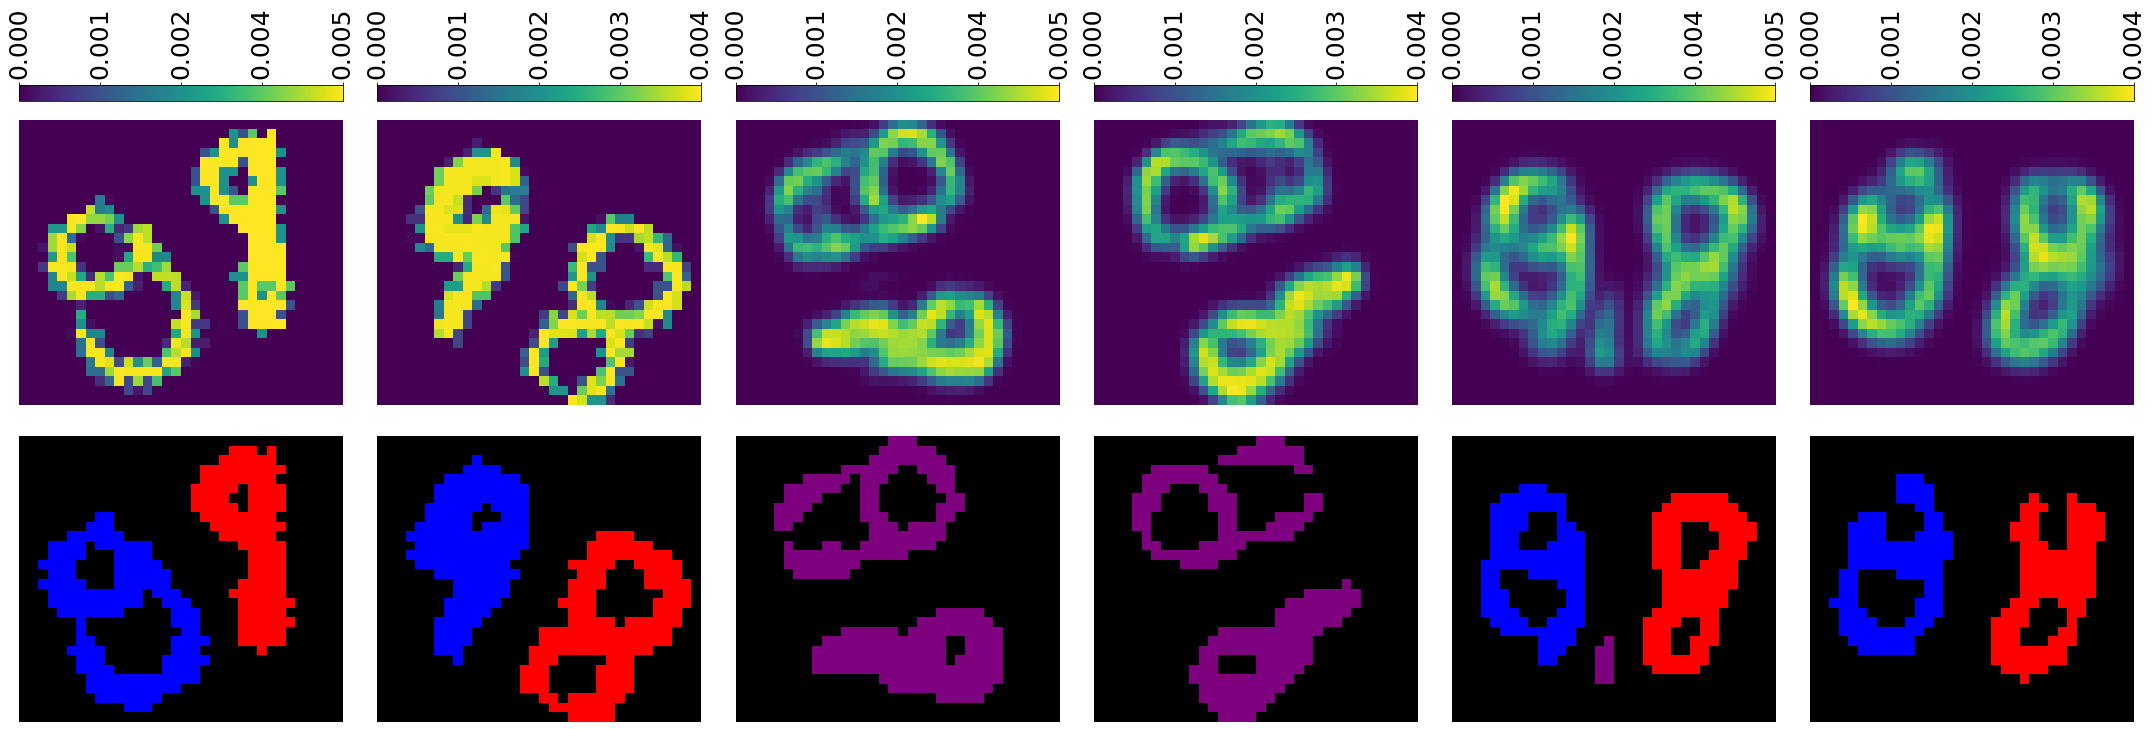

In [24]:
#full plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(2,6,figsize=(30,11))

labelsize= 25

im = ax[0,0].imshow(data[0]/np.sum(data[0]))
ax[0,0].axis("off")
ticks = (np.arange(5)/4)*np.max(data[0]/np.sum(data[0]))
cb = plt.colorbar(im,ax=ax[0,0],orientation="horizontal",location="top",ticks = ticks,format="%.3f")
cb.ax.tick_params(labelsize=labelsize,labelrotation = 90)

im = ax[0,1].imshow(data[1]/np.sum(data[1]))
ax[0,1].axis("off")
ticks = (np.arange(5)/4)*np.max(data[1]/np.sum(data[1]))
cb = plt.colorbar(im,ax=ax[0,1],orientation="horizontal",location="top",ticks = ticks,format="%.3f")
cb.ax.tick_params(labelsize=labelsize,labelrotation = 90)

ax[1,0].imshow(data_col[0])
ax[1,0].axis("off")

ax[1,1].imshow(data_col[1])
ax[1,1].axis("off")

for i in range(4):
    im = ax[0,i+2].imshow(barylist[i])
    ax[1,i+2].imshow(barylist_col[i])
    
    ticks = (np.arange(5)/4)*np.max(barylist[i])
    cb = plt.colorbar(im,ax=ax[0,i+2],orientation="horizontal",location="top",ticks = ticks,format="%.3f")
    cb.ax.tick_params(labelsize=labelsize,labelrotation = 90)

    
    ax[0,i+2].axis("off")
    ax[1,i+2].axis("off")
    
plt.tight_layout()
plt.show()